In [135]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [136]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

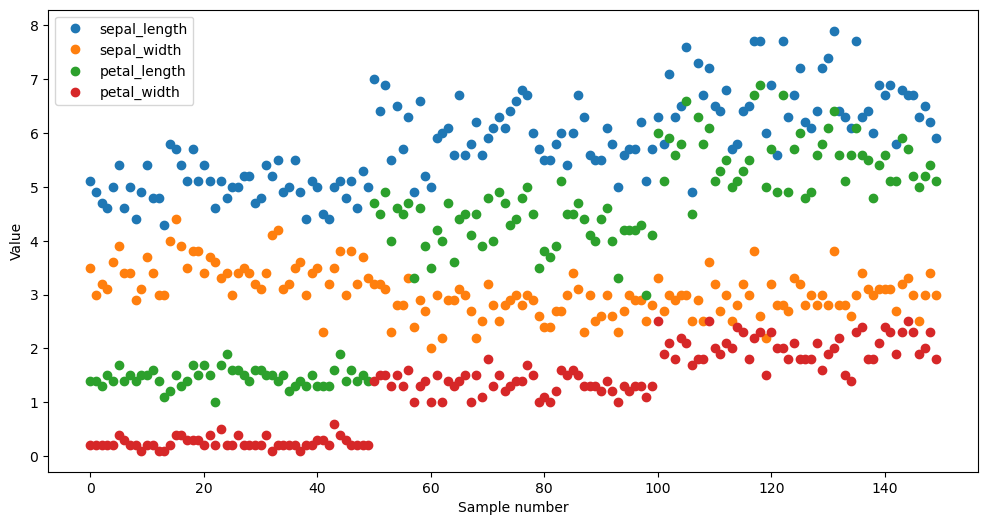

In [137]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

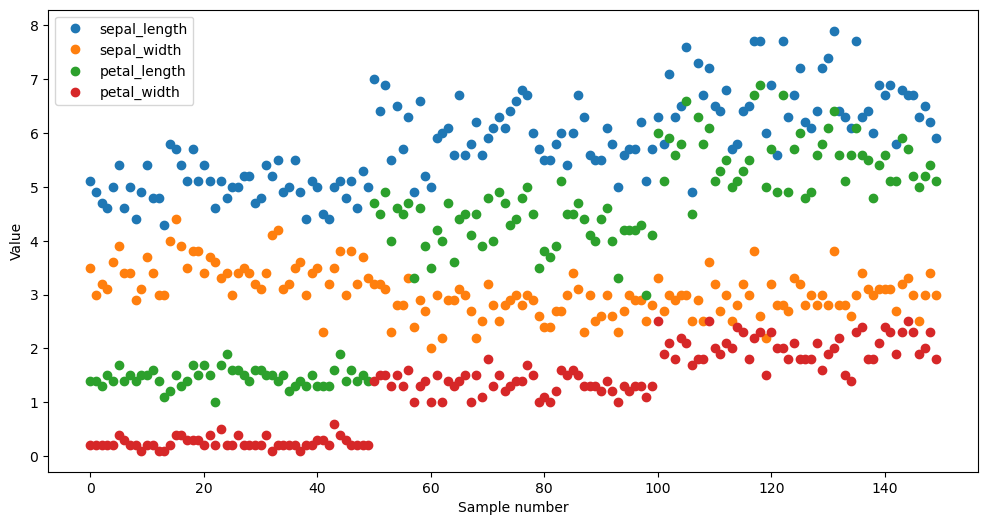

In [138]:
# z-score the data
import scipy.stats as stats
# Import the `stats` module from the `scipy` library, which provides statistical functions.

cols2zscore = iris.keys()
# Get the column names (features) of the 'iris' dataset and store them in the 'cols2zscore' variable.

cols2zscore = cols2zscore.drop('species')
# Remove the 'species' column from the 'cols2zscore' variable. This column likely contains categorical data
# and is not suitable for z-score standardization.

# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)
# Calculate the z-scores for the columns listed in 'cols2zscore' and update the 'iris' dataset with the standardized values.
# This step standardizes (centers and scales) the numerical columns so that they have a mean of 0 and a standard deviation of 1.

iris.plot(marker='o', linestyle='none', figsize=(12, 6))
# Create a scatter plot of the 'iris' dataset with markers represented as circles ('o').
# 'linestyle='none'' ensures that there are no lines connecting the markers.
# 'figsize=(12, 6)' sets the size of the figure to be displayed.

plt.xlabel('Sample number')
plt.ylabel('Value')
# Set labels for the x and y axes of the plot.

plt.show()
# Display the plot to visualize the standardized data.


In [139]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [140]:
# use scikit-learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)
# Split the 'data' and 'labels' into training and testing sets using scikit-learn's 'train_test_split' function.
# - 'data': The dataset containing input features.
# - 'labels': The corresponding labels or target values.
# - 'test_size=.2': Specifies that 20% of the data should be used for testing, and 80% for training.

# train_data = torch.from_numpy(stats.zscore(train_data.numpy(), axis=0)).float()
# # Verify standardization for each column
# for col in range(train_data.shape[1]):
#     mean = torch.mean(train_data[:, col]).item()
#     std = torch.std(train_data[:, col]).item()
#     print(f"Column {col}:")
#     print(f"  Mean: {mean:.8f}")
#     print(f"  Std:  {std:.8f}")

# This is also wrong, check Hands-on Machine Learning P79 for `inverse_transform`
# test_data = torch.from_numpy(stats.zscore(test_data.numpy(), axis=0)).float()

train_mean = torch.mean(train_data, dim=0)  # Note: use dim instead of axis for PyTorch
train_std = torch.std(train_data, dim=0)

# 2. Apply standardization using these parameters to both sets
train_data_scaled = (train_data - train_mean) / train_std
test_data_scaled = (test_data - train_mean) / train_std

# 3. To reverse/inverse transform any predictions or scaled data:
def inverse_transform(scaled_data):
    return (scaled_data * train_std) + train_mean

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data_scaled, train_labels)
test_data = TensorDataset(test_data_scaled, test_labels)

# Convert the training and testing data and labels into PyTorch Dataset objects.
# These Datasets are suitable for use with PyTorch data loaders.

# finally, translate into DataLoader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
# Create DataLoader objects for the training and testing datasets.
# - 'batch_size=batchsize': Set the batch size for the training data loader to 16.
# - 'shuffle=True': Shuffle the training data in each epoch.
# - 'drop_last=True': Drop the last batch if its size is smaller than the specified batch size for training.
# - 'batch_size=test_data.tensors[0].shape[0]': Set the batch size for the testing data loader to be the size of the entire test dataset.
#   This means that the testing data will be evaluated in a single batch.


In [141]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


# Construct the model and training plans

In [142]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4, 64),   # Input layer: 4 input features, 64 output units (neurons)
      nn.ReLU(),          # Activation function: Rectified Linear Unit (ReLU)
      nn.Linear(64, 64),  # Hidden layer: 64 input units, 64 output units
      nn.ReLU(),          # Activation function: ReLU
      nn.Linear(64, 3),   # Output layer: 64 input units, 3 output units (for classification)
  )

  # loss function
  lossfun = nn.CrossEntropyLoss()
  # Define the loss function as Cross Entropy Loss, which is commonly used for classification tasks.
  # This loss function is suitable for multi-class classification problems.

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.0005)
  # Create an SGD (Stochastic Gradient Descent) optimizer to update the model's parameters during training.
  # 'ANNiris.parameters()' specifies the model's parameters that need to be optimized.
  # 'lr=.0005' sets the learning rate for the optimizer, controlling the step size during parameter updates.

  return ANNiris, lossfun, optimizer
  # Return the created neural network model (`ANNiris`), the chosen loss function (`lossfun`), and the optimizer (`optimizer`).


In [143]:
# train the model

# global parameter
numepochs = 2500
# Set the number of training epochs to 2500. This defines how many times the entire training dataset is used for training.

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):
    # Iterate over the specified number of training epochs.

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X, y in train_loader:
      # Iterate over mini-batches of training data.

      # forward pass and loss
      yHat = ANNiris(X)
      # Perform a forward pass through the neural network (`ANNiris`) to get predictions.

      loss = lossfun(yHat, y)
      # Calculate the loss by comparing the predicted values (`yHat`) with the true labels (`y`).

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Perform backpropagation to update the model's parameters based on the computed gradients.

      # compute training accuracy just for this batch
      batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
      # Calculate the training accuracy for this mini-batch.
      # - `torch.argmax(yHat, axis=1)` finds the index of the maximum predicted value for each sample.
      # - `(torch.argmax(yHat, axis=1) == y)` checks if the predicted labels match the true labels.
      # - `torch.mean(...).item()` calculates the accuracy as a percentage.

      batchLoss.append(loss.item())
      # Append the loss for this mini-batch to the list of batch losses.
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    # Calculate and store the average training accuracy across all mini-batches for this epoch.

    losses.append(np.mean(batchLoss))
    # Calculate and store the average loss across all mini-batches for this epoch.

    # test accuracy
    X, y = next(iter(test_loader))
    # Extract a mini-batch of testing data and labels for evaluation.

    predlabels = torch.argmax(ANNiris(X), axis=1)
    # Get the predicted labels for the testing data using the trained model.

    testAcc.append(100 * torch.mean((predlabels == y).float()).item())
    # Calculate and store the testing accuracy for this epoch.
    # - `predlabels == y` checks if the predicted labels match the true labels.
    # - `torch.mean(...).item()` calculates the accuracy as a percentage.
  
  # function output
  return trainAcc, testAcc, losses
  # Return the training accuracies, testing accuracies, and losses as output from the training function.



# Test it out

In [144]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()


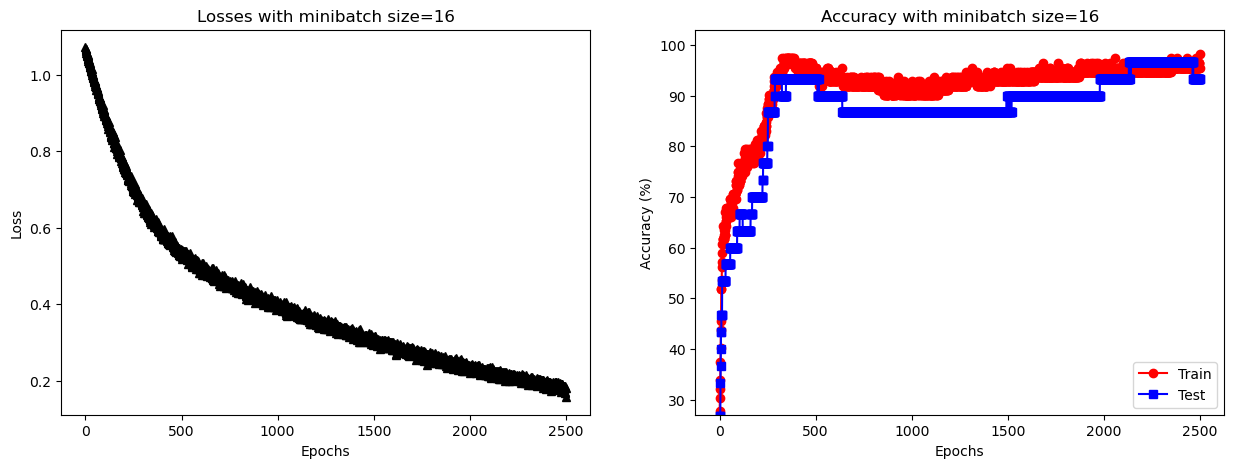

In [145]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# Additional explorations

In [146]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects 
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
# 
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or 
#    "other." What would you have to change in the data and in the model to make this work?
# 
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the 
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
# 

### Reflection

1. Data leakage when normalization